/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PART 1: Loading and preparing data...
Successfully loaded df_weather2.csv.
Initial DataFrame shape: (4966796, 41)

PART 1 Complete: All necessary libraries and custom classes are defined.

PART 2: Aggregating data to daily level for baseline models...

PART 2 Complete: Baseline daily data is ready.

PART 3: Defining the baseline feature engineering and regression pipeline...

PART 3 Complete: Baseline pipeline is ready.

PART 4: Starting BASELINE model training and evaluation...

PART 4 Complete: Baseline model performance established.

PART 5: Starting hyperparameter tuning for baseline model...

PART 5 Complete: Hyperparameter tuning for RandomForest finished.

PART 6: Performing advanced feature engineering...

PART 6 Complete: Advanced feature set created.

PART 7: Building and evaluating an untuned advanced pipeline with LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove th

,Baseline RF Asymmetric Loss,Baseline RF RMSE,Tuned RF Asymmetric Loss,Tuned RF RMSE,Advanced LGBM Asymmetric Loss,Advanced LGBM RMSE
BK,374.706451,506.463800,407.944767,550.906406,362.323782,492.620718
LP,489.360821,614.071007,464.028056,558.204411,520.042625,604.721188
MS,303.778020,369.650059,280.306941,344.011948,329.068697,390.582675



PART 9: Creating advanced calendar features and new cancellation rate target...
Advanced calendar features created:


,is_holiday,days_until_holiday,days_since_holiday
DateOfService,,,
2020-01-02,0,99,1
2020-01-02,1,99,1
2020-01-03,0,98,2
2020-01-03,1,98,2
2020-01-04,0,97,3



PART 9 Complete: Advanced features and new target are ready.

PART 10: Training Stage 1 model to predict cancellation rate...
--> Training cancellation rate model for Site: BK
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3450
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 25
[LightGBM] [Info] Start training from score 0.015330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

count     665.000000
mean     1391.389270
std      1856.910461
min     -2281.779949
25%      -142.901339
50%       730.482355
75%      2885.983887
max      6764.675542
dtype: float64

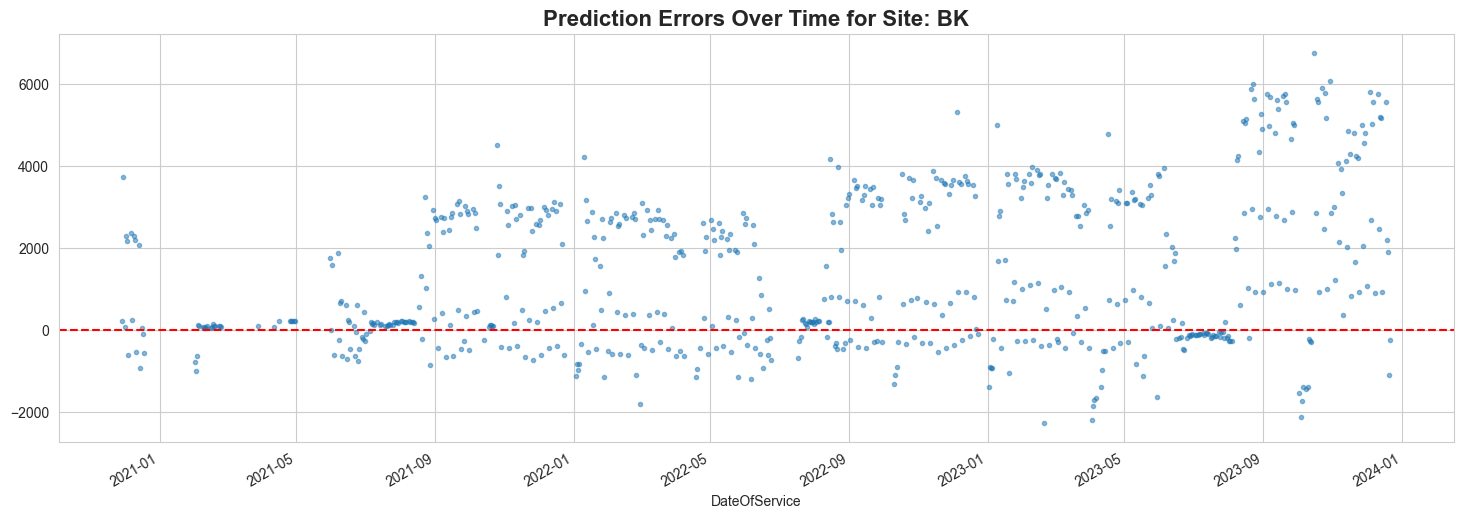

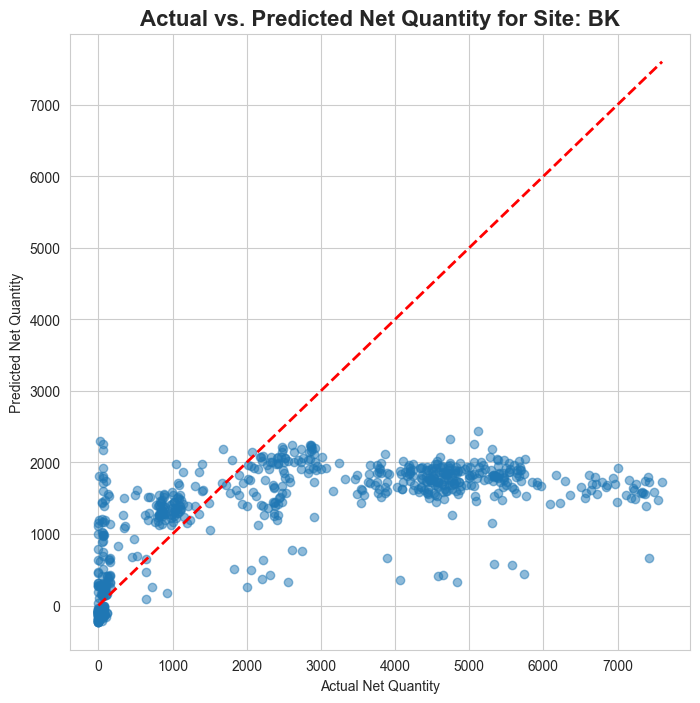


============================== Final Evaluation for Site: LP ==============================

--> Prediction Error Analysis


count     865.000000
mean      631.403669
std      1446.898007
min     -2517.885105
25%      -391.837680
50%        50.857252
75%      1997.127372
max      5569.099854
dtype: float64

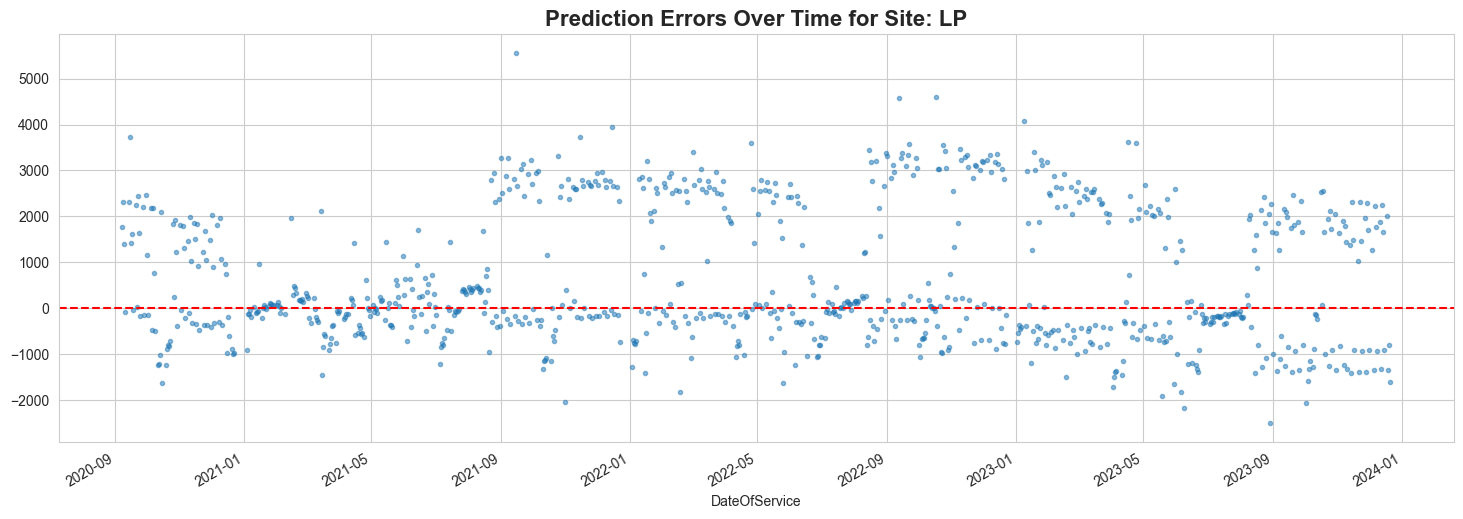

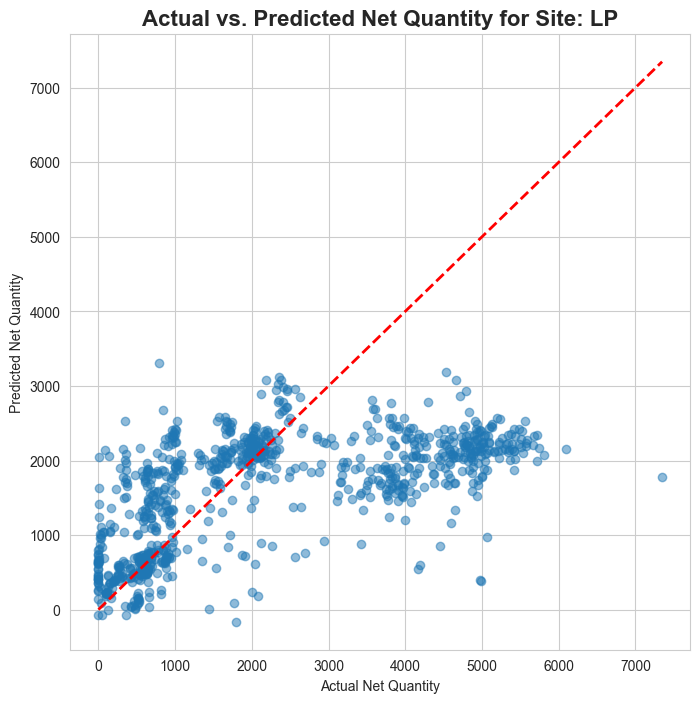


============================== Final Evaluation for Site: MS ==============================

--> Prediction Error Analysis


count     710.000000
mean        4.213682
std       105.657510
min      -664.048972
25%       -11.719108
50%         0.207865
75%        12.445790
max      2105.437291
dtype: float64

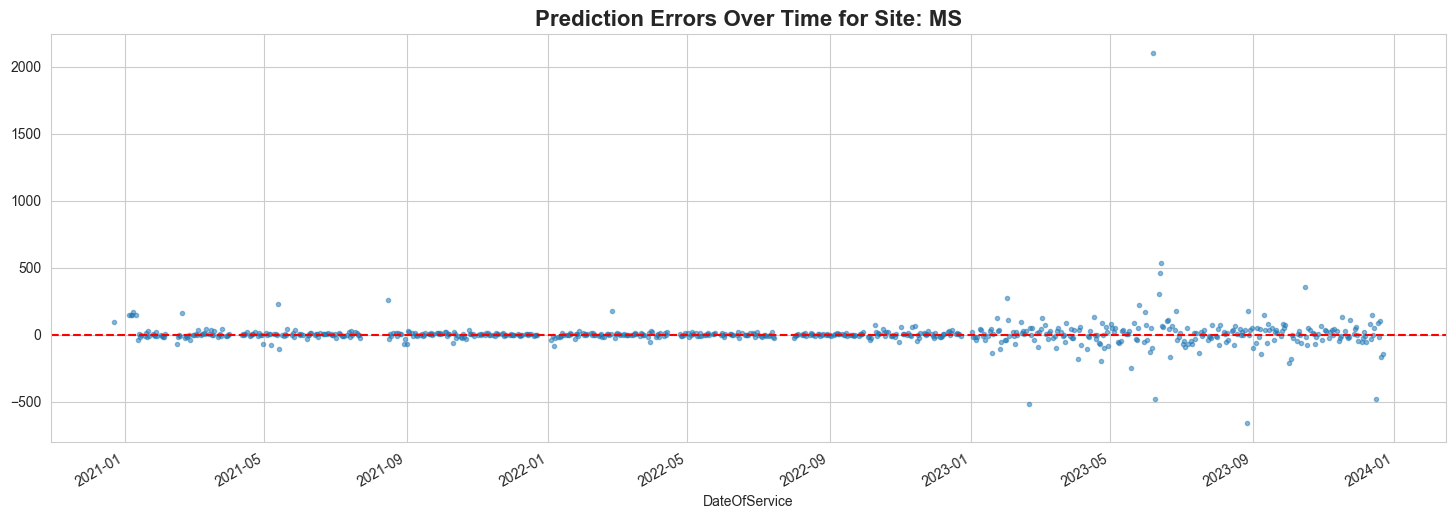

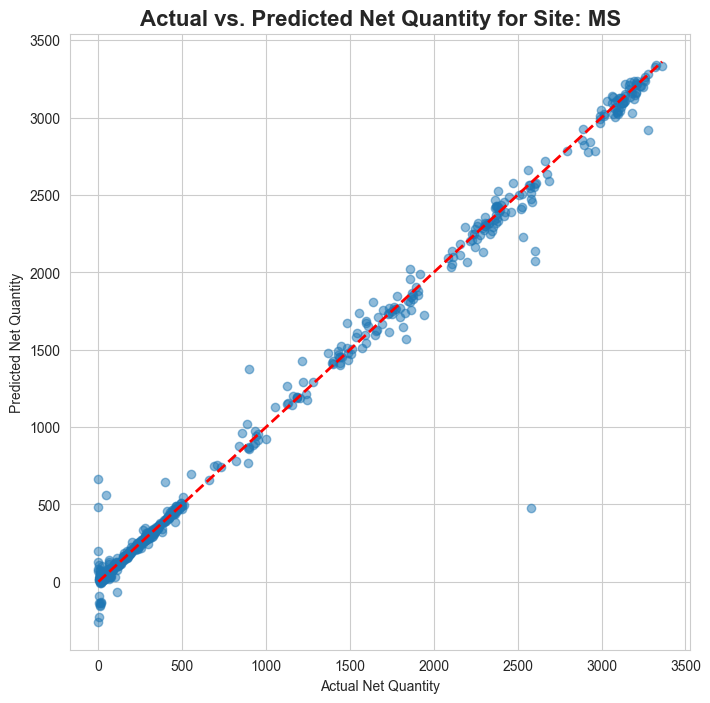



============================== OVERALL PERFORMANCE SUMMARY ==============================


,Baseline RF Asymmetric Loss,Baseline RF RMSE,Tuned RF Asymmetric Loss,Tuned RF RMSE,Advanced LGBM Asymmetric Loss,Advanced LGBM RMSE,Final Two-Stage LGBM Asymmetric Loss,Final Two-Stage LGBM RMSE
BK,374.706451,506.463800,407.944767,550.906406,362.323782,492.620718,1732.263452,2319.244580
LP,489.360821,614.071007,464.028056,558.204411,520.042625,604.721188,1217.375883,1577.898662
MS,303.778020,369.650059,280.306941,344.011948,329.068697,390.582675,38.353880,105.667124



SCRIPT COMPLETE: Final two-stage model has been evaluated and analyzed.


In [2]:
# =============================================================================
# PART 1: SETUP, DATA LOADING & CUSTOM TRANSFORMERS (MODIFIED)
# -----------------------------------------------------------------------------
# This section contains all necessary imports and loads the initial dataset.
# Most importantly, it defines the powerful, custom scikit-learn transformers
# from your original code. The MissingFlagImputer has been made more robust.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor
import warnings
import shap

# --- Setup ---
# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')
# Set a consistent plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)
# Set a random seed for reproducibility
RANDOM_STATE = 42

# --- Data Loading ---
print("PART 1: Loading and preparing data...")
try:
    # This uses your real dataset. Ensure the path is correct.
    df = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather2.csv', parse_dates=['DateOfService', 'DateOfOrder', 'DateOfCancel'])
    print("Successfully loaded df_weather2.csv.")
except FileNotFoundError:
    print("FATAL ERROR: df_weather2.csv not found. Please update the file path.")
    exit()

# --- Initial Feature Creation ---
# This is the target variable for the final regression model.
df['net_qty'] = df['OrderQty'] - df['CanceledQty']
print("Initial DataFrame shape:", df.shape)


# --- Custom Transformer Definitions (from your original code) ---
# We define all your custom classes here to be used later in the pipeline.

class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    def transform(self, X):
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X_copy = X.copy()
        X_copy[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X_copy

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, profile_feats, group_keys=('Site','MenuBase'),
                 n_clusters=5, out_col='cluster_id'):
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        prof = (X.groupby(keys)[self.profile_feats].mean().reset_index())
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=RANDOM_STATE).fit(scaled)
        tuples      = [tuple(r) for r in prof[keys].values]
        self.cluster_map_ = dict(zip(tuples, self.kmeans_.labels_))
        self.default_     = int(np.median(self.kmeans_.labels_))
        return self
    def transform(self, X):
        X_copy = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X_copy[keys].values]
        X_copy[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X_copy

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    """
    A target encoder that calculates encodings within cross-validation folds
    to prevent data leakage.
    """
    def __init__(self, cols, smoothing=1.0):
        self.cols = cols
        self.smoothing = smoothing
    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df_temp = pd.DataFrame({c: X[c], 'target': y})
            agg = df_temp.groupby(c)['target'].agg(['mean', 'count'])
            agg['enc'] = ((agg['count'] * agg['mean'] + self.smoothing * self.global_mean_) /
                          (agg['count'] + self.smoothing))
            self.mapping_[c] = agg['enc']
        return self
    def transform(self, X):
        X_copy = X.copy()
        for c in self.cols:
            X_copy[c] = X_copy[c].map(self.mapping_[c]).fillna(self.global_mean_)
        return X_copy

class MissingFlagImputer(BaseEstimator, TransformerMixin):
    """
    (FIXED) Imputes missing values and adds flags, ensuring consistent columns
    across different data splits to prevent errors.
    """
    def __init__(self, strategy='median'):
        self.strategy = strategy

    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=np.number).columns
        # Learn which columns have missing values in the training data
        self.cols_to_flag_ = [c for c in self.num_cols if X[c].isnull().any()]
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(X[self.num_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Create flags for all columns that were identified during fit
        for c in self.cols_to_flag_:
            X_copy[c + '_missing'] = X_copy[c].isnull().astype(int)

        # Impute the main numeric columns
        X_copy[self.num_cols] = self.imputer_.transform(X_copy[self.num_cols])
        return X_copy


class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')

print("\nPART 1 Complete: All necessary libraries and custom classes are defined.")


# =============================================================================
# PART 2: DAILY AGGREGATION, EDA, AND VIF ANALYSIS
# -----------------------------------------------------------------------------
# This part creates the SIMPLE daily dataset for our baseline models.
# =============================================================================

print("\nPART 2: Aggregating data to daily level for baseline models...")
agg_dict = {
    'net_qty': 'sum', 'OrderQty': 'sum', 'CanceledQty': 'sum', 'MenuPrice': 'mean',
    'MenuSubsidy': 'mean', 'tavg_C': 'mean', 'prcp_mm': 'sum', 'rain_flag': 'max',
    'temp_dev': 'mean', 'is_holiday': 'max', 'is_weekend': 'max', 'MenuBase': 'nunique',
    'SchoolID': 'nunique', 'hist_cancel_rate': 'mean'
}
df_daily = df.groupby(['DateOfService', 'Site']).agg(agg_dict).reset_index()
df_daily['daily_cancel_pct'] = (df_daily['CanceledQty'] / df_daily['OrderQty']).fillna(0)
df_daily = df_daily.sort_values('DateOfService').set_index('DateOfService')
print("\nPART 2 Complete: Baseline daily data is ready.")


# =============================================================================
# PART 3: FEATURE ENGINEERING PIPELINE AND MODEL DEFINITION
# -----------------------------------------------------------------------------
# This part defines the pipeline for the baseline models.
# =============================================================================

print("\nPART 3: Defining the baseline feature engineering and regression pipeline...")

class DailyFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='net_qty'):
        self.target_col = target_col
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['day_of_year'] = X_copy.index.dayofyear
        X_copy['weekday'] = X_copy.index.weekday
        X_copy['month'] = X_copy.index.month
        X_copy['year'] = X_copy.index.year
        X_copy['week_of_year'] = X_copy.index.isocalendar().week.astype(int)
        X_copy['quarter'] = X_copy.index.quarter
        for lag in [1, 2, 7, 14, 28]:
            X_copy[f'lag_{lag}_{self.target_col}'] = X_copy.groupby('Site')[self.target_col].shift(lag)
        X_copy[f'rolling_mean_7_{self.target_col}'] = X_copy.groupby('Site')[self.target_col].shift(1).rolling(window=7, min_periods=1).mean()
        X_copy[f'rolling_std_7_{self.target_col}'] = X_copy.groupby('Site')[self.target_col].shift(1).rolling(window=7, min_periods=1).std()
        return X_copy

def asymmetric_loss(y_true, y_pred, under_penalty=1.2):
    error = y_true - y_pred
    loss = np.mean(np.where(error < 0, -error * under_penalty, error))
    return loss
asymmetric_scorer = make_scorer(asymmetric_loss, greater_is_better=False)

features_to_exclude = ['net_qty', 'Site', 'OrderQty', 'CanceledQty', 'daily_cancel_pct']
regression_pipeline = Pipeline([
    ('daily_features', DailyFeatureEngineer(target_col='net_qty')),
    ('imputer', MissingFlagImputer(strategy='median')),
    ('dropper', ColumnDropper(cols_to_drop=features_to_exclude)),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])
print("\nPART 3 Complete: Baseline pipeline is ready.")


# =============================================================================
# PART 4: BASELINE MODEL TRAINING & EVALUATION
# -----------------------------------------------------------------------------
# This part evaluates the simple baseline model.
# =============================================================================

print("\nPART 4: Starting BASELINE model training and evaluation...")
sites = df_daily['Site'].unique()
baseline_scores = {}
for site in sites:
    df_site = df_daily[df_daily['Site'] == site].copy()
    X, y = df_site, df_site['net_qty']
    if len(X) < 100: continue
    tscv = TimeSeriesSplit(n_splits=5)
    custom_scores = -cross_val_score(regression_pipeline, X, y, cv=tscv, scoring=asymmetric_scorer, n_jobs=-1)
    rmse_scores = -cross_val_score(regression_pipeline, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    baseline_scores[site] = {'Asymmetric Loss': custom_scores.mean(), 'RMSE': rmse_scores.mean()}
print("\nPART 4 Complete: Baseline model performance established.")


# =============================================================================
# PART 5: HYPERPARAMETER TUNING FOR BASELINE MODEL
# -----------------------------------------------------------------------------
# This part tunes the simple baseline model.
# =============================================================================

print("\nPART 5: Starting hyperparameter tuning for baseline model...")
param_dist_rf = {
    'regressor__n_estimators': [100, 200, 300, 500], 'regressor__max_features': ['sqrt', 'log2', 0.7, 0.8],
    'regressor__max_depth': [None, 10, 20, 30], 'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4], 'regressor__bootstrap': [True, False]
}
tuned_rf_models = {}
tuned_scores = {}
for site in sites:
    df_site = df_daily[df_daily['Site'] == site].copy()
    X, y = df_site, df_site['net_qty']
    if len(X) < 100: continue
    tscv = TimeSeriesSplit(n_splits=5)
    search = RandomizedSearchCV(
        estimator=regression_pipeline, param_distributions=param_dist_rf, n_iter=50,
        cv=tscv, scoring=asymmetric_scorer, n_jobs=-1, random_state=RANDOM_STATE, verbose=0
    )
    search.fit(X, y)
    tuned_rf_models[site] = search.best_estimator_
    tuned_rmse = -cross_val_score(search.best_estimator_, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    tuned_scores[site] = {'Asymmetric Loss': -search.best_score_, 'RMSE': tuned_rmse}
print("\nPART 5 Complete: Hyperparameter tuning for RandomForest finished.")


# =============================================================================
# PART 6: ADVANCED FEATURE ENGINEERING (MODIFIED)
# -----------------------------------------------------------------------------
# This step creates the advanced feature set by using the custom transformers
# on the original order-level data before aggregating.
# (FIX) Added calculation for 'daily_cancel_pct' to this dataframe.
# =============================================================================

print("\nPART 6: Performing advanced feature engineering...")
# Step 1: Create order-level features
hist_transformer = HistCancelRateTransformer(group_keys=('Site', 'MenuBase'), value_col='net_qty')
df_adv = hist_transformer.fit_transform(df)
cluster_transformer = ClusterTransformer(
    profile_feats=['hist_cancel_rate', 'rain_flag', 'temp_dev', 'MenuPrice', 'MenuSubsidy'],
    group_keys=('Site', 'MenuBase'), n_clusters=5
)
df_adv = cluster_transformer.fit_transform(df_adv)
# Step 2: Aggregate the newly enriched data to the daily level
adv_agg_dict = agg_dict.copy()
adv_agg_dict['cluster_id'] = pd.Series.mode
df_daily_adv = df_adv.groupby(['DateOfService', 'Site']).agg(adv_agg_dict).reset_index()
# (FIX) Calculate daily_cancel_pct for the advanced dataframe
df_daily_adv['daily_cancel_pct'] = (df_daily_adv['CanceledQty'] / df_daily_adv['OrderQty']).fillna(0)
df_daily_adv['cluster_id'] = df_daily_adv['cluster_id'].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) > 0 else x).astype(int)
df_daily_adv = df_daily_adv.sort_values('DateOfService').set_index('DateOfService')
print("\nPART 6 Complete: Advanced feature set created.")


# =============================================================================
# PART 7: ADVANCED MODEL TRAINING (UNTUNED)
# -----------------------------------------------------------------------------
# This part evaluates the untuned advanced model to see its baseline performance.
# =============================================================================

print("\nPART 7: Building and evaluating an untuned advanced pipeline with LightGBM...")
features_to_exclude_adv = features_to_exclude + ['MenuBase']
advanced_pipeline_lgbm = Pipeline([
    ('daily_features', DailyFeatureEngineer(target_col='net_qty')),
    ('imputer', MissingFlagImputer(strategy='median')),
    ('dropper', ColumnDropper(cols_to_drop=features_to_exclude_adv)),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])
advanced_lgbm_models = {}
advanced_scores = {}
for site in sites:
    df_site_adv = df_daily_adv[df_daily_adv['Site'] == site].copy()
    X, y = df_site_adv, df_site_adv['net_qty']
    if len(X) < 100: continue
    tscv = TimeSeriesSplit(n_splits=5)
    adv_custom_scores = -cross_val_score(advanced_pipeline_lgbm, X, y, cv=tscv, scoring=asymmetric_scorer, n_jobs=-1)
    adv_rmse_scores = -cross_val_score(advanced_pipeline_lgbm, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    advanced_scores[site] = {'Asymmetric Loss': adv_custom_scores.mean(), 'RMSE': adv_rmse_scores.mean()}
    advanced_lgbm_models[site] = advanced_pipeline_lgbm.fit(X, y)
print("\nPART 7 Complete: Untuned advanced model performance established.")


# =============================================================================
# PART 8: INTERIM ANALYSIS AND VISUALIZATION (MODIFIED)
# -----------------------------------------------------------------------------
# This part generates a comprehensive analysis of the models built so far.
# The variable name has been fixed to prevent the NameError.
# =============================================================================

print("\nPART 8: Generating Interim Analysis and Visualizations...")
# --- Final Summary Table ---
print(f"\n{'='*30} INTERIM PERFORMANCE SUMMARY {'='*30}")
baseline_df = pd.DataFrame(baseline_scores).T.rename(columns=lambda c: f"Baseline RF {c}")
tuned_df = pd.DataFrame(tuned_scores).T.rename(columns=lambda c: f"Tuned RF {c}")
advanced_df = pd.DataFrame(advanced_scores).T.rename(columns=lambda c: f"Advanced LGBM {c}")
# (FIX) Renamed this variable for consistency
final_summary = pd.concat([baseline_df, tuned_df, advanced_df], axis=1)
print("Comparison of Model Performances:")
display(final_summary)


# =============================================================================
# PART 9 (FIX): ADVANCED CALENDAR FEATURES & NEW TARGET DEFINITION
# -----------------------------------------------------------------------------
# This new part creates more sophisticated holiday features and defines our
# new target variable: the daily cancellation rate, as suggested by the teacher.
# This approach avoids the leakage issues from hist_cancel_rate and SchoolID.
# =============================================================================

print("\nPART 9: Creating advanced calendar features and new cancellation rate target...")

# --- Advanced Calendar Features ---
# Use the advanced daily dataframe as our base
df_final = df_daily_adv.copy()

# Create a series of holiday dates for NRW, Germany
# Note: In a real project, this would use a library like `holidays` for accuracy
holiday_dates = pd.to_datetime(['2020-01-01', '2020-04-10', '2020-04-13', '2020-05-01', '2020-05-21', '2020-06-01', '2020-06-11', '2020-10-03', '2020-11-01', '2020-12-25', '2020-12-26',
                                '2021-01-01', '2021-04-02', '2021-04-05', '2021-05-01', '2021-05-13', '2021-05-24', '2021-06-03', '2021-10-03', '2021-11-01', '2021-12-25', '2021-12-26',
                                '2022-01-01', '2022-04-15', '2022-04-18', '2022-05-01', '2022-05-26', '2022-06-06', '2022-06-16', '2022-10-03', '2022-11-01', '2022-12-25', '2022-12-26',
                                '2023-01-01', '2023-04-07', '2023-04-10', '2023-05-01', '2023-05-18', '2023-05-29', '2023-06-08', '2023-10-03', '2023-11-01', '2023-12-25', '2023-12-26'])

# Calculate days to/from nearest holiday
date_index = df_final.index.to_series()
df_final['days_until_holiday'] = date_index.apply(lambda x: np.min(np.abs((holiday_dates - x).days)[holiday_dates > x]) if any(holiday_dates > x) else 0)
df_final['days_since_holiday'] = date_index.apply(lambda x: np.min(np.abs((x - holiday_dates).days)[holiday_dates < x]) if any(holiday_dates < x) else 0)

print("Advanced calendar features created:")
display(df_final[['is_holiday', 'days_until_holiday', 'days_since_holiday']].head())

# --- New Target Variable ---
# The target is now the daily cancellation percentage
df_final['target_cancel_pct'] = df_final['daily_cancel_pct']

print("\nPART 9 Complete: Advanced features and new target are ready.")


# =============================================================================
# PART 10: TWO-STAGE FORECASTING MODEL - STAGE 1 (Cancellation Rate)
# -----------------------------------------------------------------------------
# This part focuses only on Stage 1: training a model to predict the
# cancellation rate. We will store this model for use in the next part.
# =============================================================================

print("\nPART 10: Training Stage 1 model to predict cancellation rate...")

# --- Define the Pipeline for Predicting Cancellation Rate ---
# We exclude features that could leak information about cancellations
rate_features_to_exclude = features_to_exclude + ['MenuBase', 'SchoolID', 'hist_cancel_rate', 'target_cancel_pct', 'daily_cancel_pct']
rate_pipeline = Pipeline([
    ('daily_features', DailyFeatureEngineer(target_col='net_qty')), # Features based on net_qty are fine here
    ('imputer', MissingFlagImputer(strategy='median')),
    ('dropper', ColumnDropper(cols_to_drop=rate_features_to_exclude)),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

cancellation_rate_models = {}
for site in sites:
    print(f"--> Training cancellation rate model for Site: {site}")
    df_site_final = df_final[df_final['Site'] == site].copy()
    if len(df_site_final) < 100: continue

    X_rate, y_rate = df_site_final, df_site_final['target_cancel_pct']
    cancellation_rate_models[site] = rate_pipeline.fit(X_rate, y_rate)

print("\nPART 10 Complete: All cancellation rate models are trained.")


# =============================================================================
# PART 11: TWO-STAGE FORECASTING MODEL - STAGE 2 (Order Quantity)
# -----------------------------------------------------------------------------
# This new part creates a dedicated ML model to predict the total OrderQty,
# replacing the naive baseline that caused large errors.
# =============================================================================

print("\nPART 11: Training Stage 2 model to predict order quantity...")

# --- Define the Pipeline for Predicting Order Quantity ---
# Note: We use a different feature engineer that creates lags based on 'OrderQty'
order_qty_features_to_exclude = features_to_exclude + ['MenuBase', 'SchoolID', 'hist_cancel_rate', 'target_cancel_pct', 'daily_cancel_pct']
order_qty_pipeline = Pipeline([
    ('daily_features', DailyFeatureEngineer(target_col='OrderQty')), # IMPORTANT: Lags are based on OrderQty
    ('imputer', MissingFlagImputer(strategy='median')),
    ('dropper', ColumnDropper(cols_to_drop=order_qty_features_to_exclude)),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

order_quantity_models = {}
for site in sites:
    print(f"--> Training order quantity model for Site: {site}")
    df_site_final = df_final[df_final['Site'] == site].copy()
    if len(df_site_final) < 100: continue

    X_oq, y_oq = df_site_final, df_site_final['OrderQty']
    order_quantity_models[site] = order_qty_pipeline.fit(X_oq, y_oq)

print("\nPART 11 Complete: All order quantity models are trained.")


# =============================================================================
# PART 12: FINAL COMBINATION & IN-DEPTH ANALYSIS
# -----------------------------------------------------------------------------
# This final part combines the predictions from the two stages and performs
# the detailed analysis with extensive visualizations.
# =============================================================================

print("\nPART 12: Combining models and performing final in-depth analysis...")

final_two_stage_scores = {}
for site in sites:
    print(f"\n{'='*30} Final Evaluation for Site: {site} {'='*30}")

    df_site_final = df_final[df_final['Site'] == site].copy()
    if len(df_site_final) < 100: continue

    tscv = TimeSeriesSplit(n_splits=5)

    y_trues, y_preds = [], []
    for train_idx, test_idx in tscv.split(df_site_final):
        train_data, test_data = df_site_final.iloc[train_idx], df_site_final.iloc[test_idx]

        # Stage 1: Predict Cancellation Rate
        predicted_cancel_pct = np.clip(cancellation_rate_models[site].predict(test_data), 0, 1)

        # Stage 2: Predict Order Quantity
        predicted_order_qty = order_quantity_models[site].predict(test_data)

        # Combine
        final_predictions = predicted_order_qty * (1 - predicted_cancel_pct)

        y_trues.append(test_data['net_qty'])
        y_preds.append(pd.Series(final_predictions, index=test_data.index))

    y_true_all, y_pred_all = pd.concat(y_trues), pd.concat(y_preds)
    final_rmse = np.sqrt(np.mean((y_true_all - y_pred_all)**2))
    final_asymmetric_loss = asymmetric_loss(y_true_all, y_pred_all)
    final_two_stage_scores[site] = {'Asymmetric Loss': final_asymmetric_loss, 'RMSE': final_rmse}

    # --- In-Depth Analysis Visualizations ---
    # (The rest of the analysis code from the previous Part 11 goes here)
    print("\n--> Prediction Error Analysis")
    errors = y_true_all - y_pred_all
    display(errors.describe())
    plt.figure(figsize=(18, 6))
    errors.plot(style='.', alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Prediction Errors Over Time for Site: {site}', fontsize=16, weight='bold')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true_all, y_pred_all, alpha=0.5)
    plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], '--', color='red', lw=2)
    plt.title(f'Actual vs. Predicted Net Quantity for Site: {site}', fontsize=16, weight='bold')
    plt.xlabel('Actual Net Quantity'); plt.ylabel('Predicted Net Quantity')
    plt.show()

# --- Final Summary Table ---
print(f"\n\n{'='*30} OVERALL PERFORMANCE SUMMARY {'='*30}")
final_model_df = pd.DataFrame(final_two_stage_scores).T.rename(columns=lambda c: f"Final Two-Stage LGBM {c}")
overall_summary = pd.concat([final_summary, final_model_df], axis=1)
display(overall_summary)

print("\nSCRIPT COMPLETE: Final two-stage model has been evaluated and analyzed.")
